# Getting started

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
# import dill as dill
import pandas as pd
from pathlib import Path

# from ipywidgets import widgets
from scipy.interpolate import interp1d
# from matplotlib import ticker
# from matplotlib.ticker import MaxNLocator

In [3]:
# # Load the submodule, so that we are sure we use the same version
# import sys
# sys.path.insert(0, "ompy")
import ompy as om

In [4]:
# from matplotlib import rc
# rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
# rc('text', usetex=True)
# rc('axes', labelsize="large")
# rc('errorbar', capsize=2.) # Set error bar style

In [5]:
om.__full_version__

'1.1.0.dev0+a1a77cb'

In [6]:
# For reproducability we seed the random generator. 
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [7]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

## Loading raw data (particle - $\gamma$-ray coincidence matrix)
<a id='loading_data'></a>

The $^{162}\mathrm{Dy}$ data used below has been gathered from following experiment: Guttormsen *et al.* (2003). DOI: 10.1103/physrevc.68.064306
and is reanalyzed in Renstrøm, T. *et al.* (2018). DOI: [10.1103/physrevc.98.054310](https://doi.org/10.1103/PhysRevC.98.054310)

**Select dataset**

In [8]:
file_prefix = "162Dy_4He"
Ex_max = 7700 # keV

In [9]:
# fit limits for first-generation
# Ex_max -- case dependent
Ex_min = 4400
Ex_max = 8100 # keV
# Ex_max = 10000 # keV
Eg_min = 1600
Eg_max = Ex_max + 200

# number of ensemble members
N_members = 200

Path("figs").mkdir(exist_ok=True)

**Important Note:**
With the `regernerate` flag we can adjust whether or not we read the saved files from disk. E.g., we might just want to change some plots, not rerun all calculations.

Note that the `regernerate` feature may lead to different `logger` messages when (re)running this notebook

In [10]:
regenerate_response = True
regenerate_ensemble = False

<IPython.core.display.Javascript object>


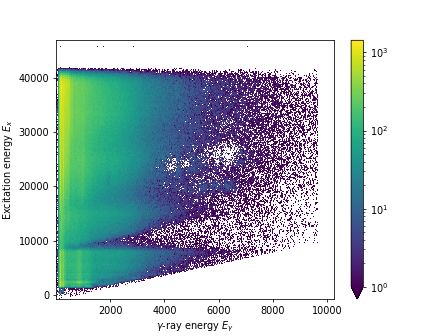

(<matplotlib.collections.QuadMesh at 0x7f121c0899e8>,
 <Figure size 448x336 with 2 Axes>)

In [11]:
raw = om.Matrix(path="data/alfna_162Dy_4He")
raw.plot(vmin=1)

<IPython.core.display.Javascript object>


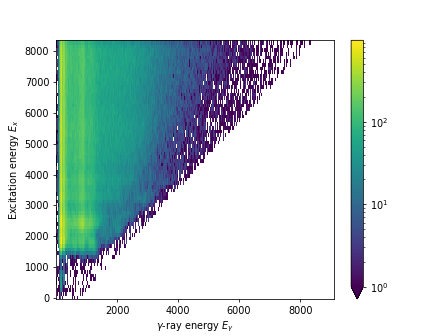

In [12]:
# Cut away unneccesary parts of the matrix 
# (-> shorter time to unfold & removed some remaining bg noise)
raw.cut_diagonal(E1=(800, 0), E2=(7500, 7300))
raw.cut('Ex', 0, Ex_max+200)
raw.cut('Eg', 0, Ex_max+1000)
raw.plot(vmin=1);

## Unfolding

### Get a response matrix

In [13]:
logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "/home/fabiobz/Desktop/Masterthesis/misc/ompy/OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 90.44 # (90/1330 = 6.8%)

fname_response_save = Path(f'saved_run/response_{file_prefix}')
fname_response_save.mkdir(exist_ok=True, parents=True)
try:
    if regenerate_response:
        raise AssertionError("regenerate set to false; fall back to normalize")
    R_ompy_unf = om.Matrix(path=fname_response_save / "R_ompy_unf.m")
    R_tab_unf = pd.read_pickle(fname_response_save / "R_tab_unf.pkl")

except (OSError, FileNotFoundError, AssertionError) as e:
    response = om.Response(folderpath)
    response.smooth_compton = True
    # Magne recommends 1/10 of the actual resolution for unfolding purposes (see article)
#     R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
    R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)
    R_ompy_unf.save(path=fname_response_save / "R_ompy_unf.m")
    R_tab_unf.to_pickle(fname_response_save / "R_tab_unf.pkl")

2020-09-24 08:36:11,349 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


For the CACTUS setup, there is an additional experimental threshold, that is not taken into account in the original response matrix

In [14]:
fthreshold = interp1d([30., 80., 122., 183., 244., 294., 344., 562., 779., 1000.],
                      [0.0, 0.0, 0.0, 0.06, 0.44, 0.60, 0.87, 0.99, 1.00, 1.00],
                      fill_value="extrapolate")

def apply_detector_threshold(response, table, fthreshold):
    thres = fthreshold(response.Eg)
    response.values = response.values * thres
    # renormalize
    response.values = om.div0(response.values, response.values.sum(axis=1)[:, np.newaxis])
    table["eff_tot"] *= thres

apply_detector_threshold(R_ompy_unf, R_tab_unf, fthreshold)

In [15]:
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
apply_detector_threshold(R_ompy_view, R_tab_view, fthreshold)

2020-09-24 08:36:22,128 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


<IPython.core.display.Javascript object>


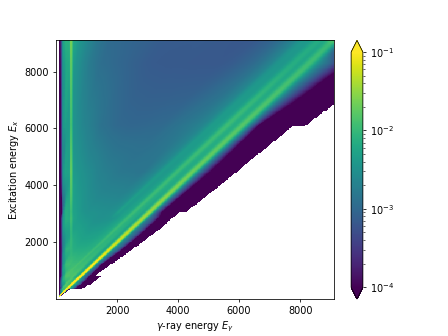

<IPython.core.display.Javascript object>


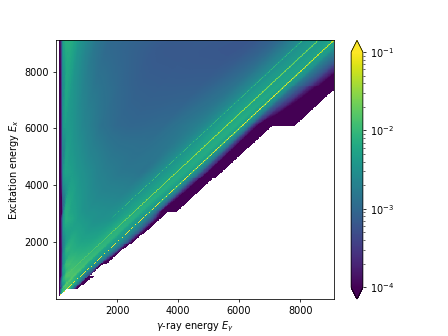

(<matplotlib.collections.QuadMesh at 0x7f121bf48b00>,
 <Figure size 448x336 with 2 Axes>)

In [16]:
R_ompy_view.plot(scale="log", vmin=1e-4, vmax=1e-1)
R_ompy_unf.plot(scale="log", vmin=1e-4, vmax=1e-1)

<IPython.core.display.Javascript object>


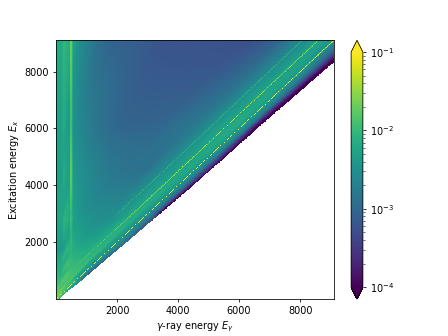

(<matplotlib.collections.QuadMesh at 0x7f121794bdd8>,
 <Figure size 448x336 with 2 Axes>)

In [17]:
resp_mama = om.Matrix(path="data/resp_4He.m")
resp_mama.cut('Eg', 0, Ex_max+1000)
resp_mama.cut('Ex', 0, Ex_max+1000)
resp_mama.plot(scale="log", vmin=1e-4, vmax=1e-1)

### Perform the unfolding & reduce statistics, if applicable

In [18]:
# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
# raw_positive.remove_negative()
raw_positive.fill_and_remove_negative()

In [19]:
def remove_nega_diagonal(mat, cut=1e-2):
    mat.fill_and_remove_negative(40)
    mat.cut_diagonal(E1=(800, 0), E2=(7500, 7300))

In [20]:
# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
# unfolder= om.Unfolder(response=resp_mama)
unfolder.response_tab = R_tab_unf
unfolder.minimum_iterations = 30
unfolder.use_compton_subtraction = False
# unfolder.num_iter = 100
unfolder.remove_negative = remove_nega_diagonal
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)

<IPython.core.display.Javascript object>


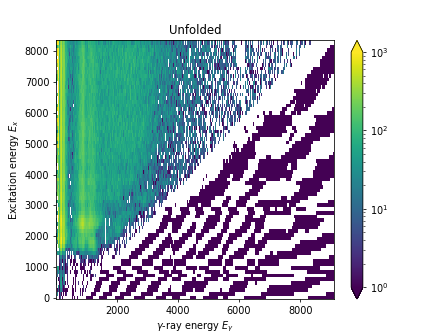

<IPython.core.display.Javascript object>


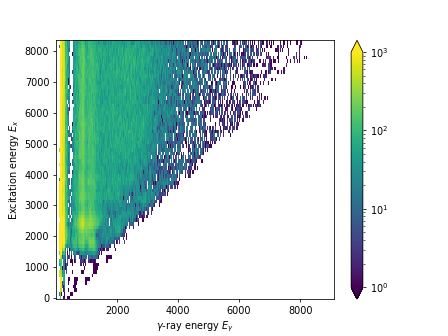

In [21]:
unfolded.plot(vmin=1, vmax=1e3);

# compare to unfolding of Renstrøm et al.
unfolded_2018 = om.Matrix(path="data/alfnaun_162Dy_4He")
unfolded_2018.cut('Ex', 0, Ex_max+200)
unfolded_2018.cut('Eg', 0, Ex_max+1000)
unfolded_2018.plot(vmin=1, vmax=1e3);

In [22]:
# limits for comparison plots below
# Emin_px = 5000
# Emax_px = 5000
Emin_px = 6000
Emax_px = 6000
# Emin_px = 7000
# Emax_px = 7000
# Emin_px = 8000
# Emax_px = 8000

<IPython.core.display.Javascript object>


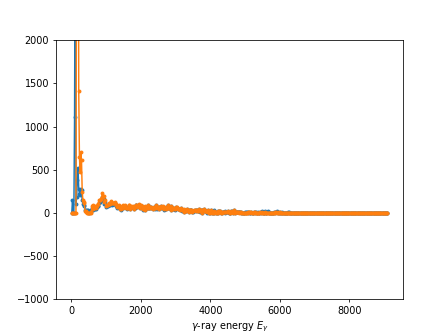

(-1000.0, 2000.0)

In [23]:
fig, ax = plt.subplots()
# raw.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px)
unfolded.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px)
unfolded_2018.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px)
ax.set_ylim(-1e3, 2e3)

There seems to be quite a large difference between the unfolded results from ompy and from mama

### Which unfolding is better: compare raw to folded(unfolded)

In [24]:
folded = unfolded.copy()
folded.values = (folded.values) @ (R_ompy_view.values*R_tab_view.eff_tot[np.newaxis, :])
# folded.values = folded.values @ resp_mama.values

# there seem to be small difference in the response
# matrixes, use the mama response on mama results

# folded_2018 = unfolded_2018.copy()
# folded_2018.values = folded_2018.values @ R_ompy_view.values

folded_2018 = unfolded_2018.copy()
folded_2018.values = folded_2018.values @ (resp_mama.values*R_tab_view.eff_tot[np.newaxis, :])

In [25]:
def plot_folded(ax):
    raw.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px, 
                        label="raw")
    folded.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px,
                          label="folded(ompy)")
    folded_2018.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px, 
                                linestyle="--", label="folded(mama/AC_12_06_2020)")

<IPython.core.display.Javascript object>


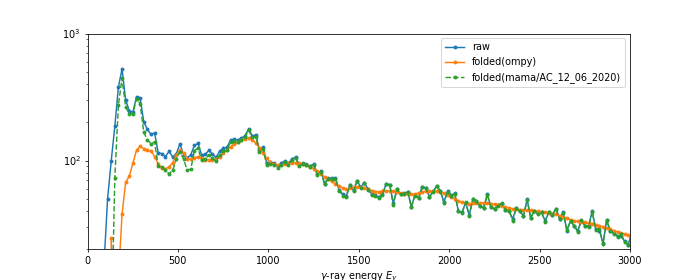

<IPython.core.display.Javascript object>


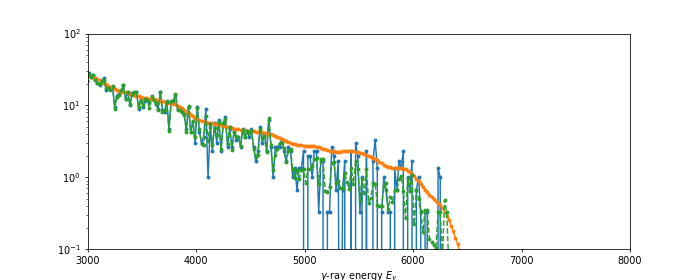

In [26]:
fig, ax = plt.subplots(figsize=(10,4))
plot_folded(ax)
ax.set_ylim(2e1, 1e3)
ax.set_xlim(0, 3e3)
ax.set_yscale("log")
ax.legend(loc="best")

fig, ax = plt.subplots(figsize=(10,4))
plot_folded(ax)
ax.set_ylim(1e-1, 1e2)
ax.set_xlim(3e3, 8e3)
ax.set_yscale("log")

<IPython.core.display.Javascript object>


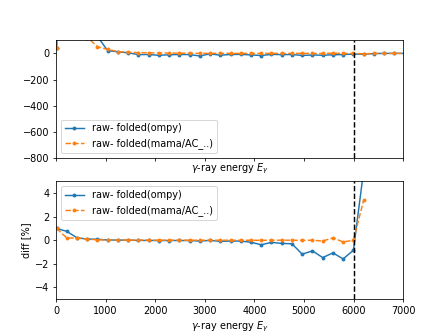

In [27]:
diff = raw-folded
diff_2018 = raw-folded_2018

diff.rebin(axis="Eg", factor=10)
diff_2018.rebin(axis="Eg", factor=10)


fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
diff.plot_projection(ax=ax1, axis="Eg", Emin=Emin_px, Emax=Emax_px,
                     label="raw- folded(ompy)")
diff_2018.plot_projection(ax=ax1, axis="Eg", Emin=Emin_px, Emax=Emax_px, linestyle="--",
                          label="raw- folded(mama/AC_..)")
ax1.axvline(Emax_px, c="k", ls="--")
ax1.legend(loc="best")
ax1.set_ylim(-8e2, 1e2)


diff /= raw.rebin(axis="Eg", factor=10, inplace=False)
diff_2018 /= raw.rebin(axis="Eg", factor=10, inplace=False)

# fig, ax = plt.subplots()

diff.plot_projection(ax=ax2, axis="Eg", Emin=Emin_px, Emax=Emax_px,
                     label="raw- folded(ompy)")
diff_2018.plot_projection(ax=ax2, axis="Eg", Emin=Emin_px, Emax=Emax_px, linestyle="--",
                          label="raw- folded(mama/AC_..)")
ax2.axvline(Emax_px, c="k", ls="--")
ax2.legend(loc="best")
ax2.set_ylim(-5, 5)
ax2.set_xlim(0, Emax_px+1000)
ax2.set_ylabel("diff [%]");

### Generate the first generation matrix

In [28]:
valley_correction = om.Vector(values=np.ones_like(unfolded.Ex), E=unfolded.Ex)
# iE1 = valley_correction.index(1500)
# iE2 = valley_correction.index(2000)
# valley_correction[iE1:iE2+1] = 0

iE1 = valley_correction.index(2000)
iE2 = valley_correction.index(2500)
valley_correction[iE1:iE2+1] = 0

firstgen = om.FirstGeneration()
firstgen.valley_correction = valley_correction
# primary = firstgen(unfolded_2018)
primary = firstgen(unfolded)

<IPython.core.display.Javascript object>


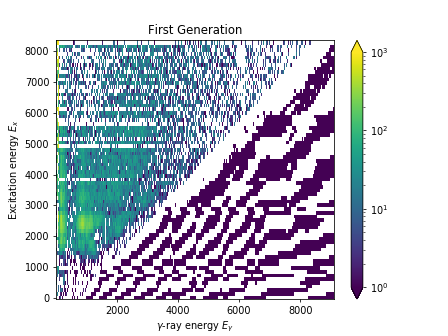

<IPython.core.display.Javascript object>


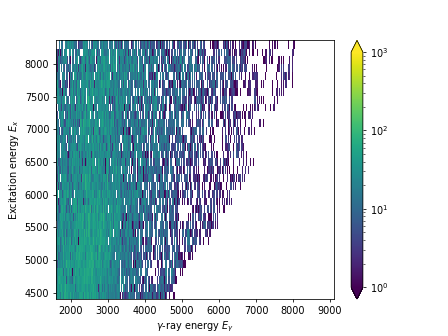

<IPython.core.display.Javascript object>


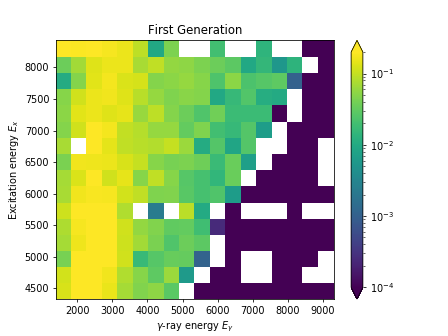

<IPython.core.display.Javascript object>


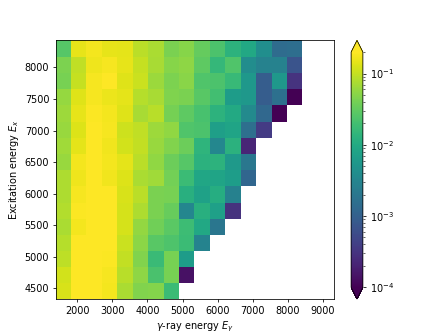

In [29]:
primary.plot(vmin=1, vmax=1e3);
# compare to unfolding of Renstrøm et al.
fg_2018 = om.Matrix(path="data/fg_162Dy_4He")
fg_2018.cut('Ex', Ex_min, Ex_max+200)
fg_2018.cut('Eg', Eg_min, Ex_max+1000)
fg_2018.plot(vmin=1, vmax=1e3);

primary.cut('Ex', Ex_min)
primary.cut('Eg', Eg_min)

primary.rebin("Eg", factor=20)
primary.rebin("Ex", factor=2)
fg_2018.rebin("Eg", factor=20)
fg_2018.rebin("Ex", factor=2)

primary.values = om.normalize_rows(primary.values)
fg_2018.values = om.normalize_rows(fg_2018.values)

primary.plot(vmin=1e-4, vmax=2e-1, scale="log");
fg_2018.plot(vmin=1e-4, vmax=2e-1, scale="log");

<IPython.core.display.Javascript object>


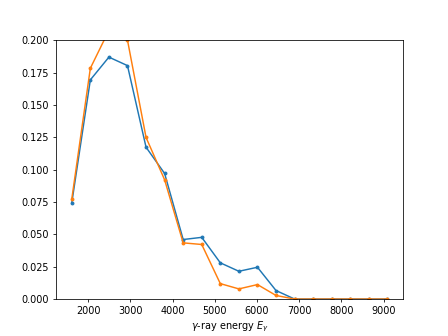

(0, 0.2)

In [30]:
fig, ax = plt.subplots()
primary.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px)
fg_2018.plot_projection(ax=ax, axis="Eg", Emin=Emin_px, Emax=Emax_px)
# ax.set_ylim(0, 500)
ax.set_ylim(0, 0.2)


## Propagating statistical uncertainties

In order to propagate the statistical uncertainties from the raw matrix, we use an ensemble based method. We start of my generating en ensemble of *raw-like* matrices. The raw counts are Poisson distributed. If we had counted one another time, we would get slightly different results. 

More precisely, the counts of the matrix containing `prompt+bg` events and the background events `bg` are each Poisson distributed, where we have `raw = (prompt+bg) - bg_ratio * bg`. The ratio `bg_ratio` is determined by the ratio of the time gate lengths taken to obtain the `prompt+bg` and `bg` spectra. If a `bg` spectrum is provided to the `Ensemble` class, it will calculate the raw spectrum according to the equation above. Otherwise, the provided `raw` spectrum itself is assumed to be Poisson distributed.

For this experiment, we currently only have the `raw` matrix available, thus we propagate the error from there.

We take the number of counts $k_i$ in bin $i$ of the raw matrix $R$ as an estimate for the Poisson parameter ("the mean") $λ_i$ . Note that it is an unbiased estimator for $λ_i$, since $E(k) = λ$. To generate a member matrix $R_l$ of the MC ensemble, we replace the counts in each bin $i$ by a random draw from the distribution $\operatorname{Poisson}(k_i)$.

The class Ensemble() provides this feature. Its basic usage is:

In [31]:
logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive,  path=f"saved_run/ensemble_{file_prefix}")
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members;
# the `regernerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(N_members, regenerate=regenerate_ensemble)

2020-09-24 08:36:40,591 - ompy.ensemble - INFO - Start normalization with 3 cpus
2020-09-24 08:36:40,667 - ompy.ensemble - INFO - Generating/loading 0
2020-09-24 08:36:40,698 - ompy.ensemble - INFO - Generating/loading 1
2020-09-24 08:36:40,735 - ompy.ensemble - INFO - Generating/loading 2
2020-09-24 08:36:40,762 - ompy.ensemble - INFO - Generating/loading 3
2020-09-24 08:36:40,798 - ompy.ensemble - INFO - Generating/loading 4
2020-09-24 08:36:40,827 - ompy.ensemble - INFO - Generating/loading 5
2020-09-24 08:36:40,867 - ompy.ensemble - INFO - Generating/loading 6
2020-09-24 08:36:40,904 - ompy.ensemble - INFO - Generating/loading 7
2020-09-24 08:36:40,932 - ompy.ensemble - INFO - Generating/loading 8
2020-09-24 08:36:40,959 - ompy.ensemble - INFO - Generating/loading 9
2020-09-24 08:36:40,985 - ompy.ensemble - INFO - Generating/loading 10
2020-09-24 08:36:41,024 - ompy.ensemble - INFO - Generating/loading 11


2020-09-24 08:36:41,055 - ompy.ensemble - INFO - Generating/loading 12
2020-09-24 08:36:41,082 - ompy.ensemble - INFO - Generating/loading 13
2020-09-24 08:36:41,108 - ompy.ensemble - INFO - Generating/loading 14
2020-09-24 08:36:41,144 - ompy.ensemble - INFO - Generating/loading 15
2020-09-24 08:36:41,170 - ompy.ensemble - INFO - Generating/loading 16
2020-09-24 08:36:41,204 - ompy.ensemble - INFO - Generating/loading 17
2020-09-24 08:36:41,225 - ompy.ensemble - INFO - Generating/loading 18
2020-09-24 08:36:41,256 - ompy.ensemble - INFO - Generating/loading 19
2020-09-24 08:36:41,278 - ompy.ensemble - INFO - Generating/loading 20
2020-09-24 08:36:41,308 - ompy.ensemble - INFO - Generating/loading 21
2020-09-24 08:36:41,335 - ompy.ensemble - INFO - Generating/loading 22
2020-09-24 08:36:41,363 - ompy.ensemble - INFO - Generating/loading 23
2020-09-24 08:36:41,380 - ompy.ensemble - INFO - Generating/loading 24
2020-09-24 08:36:41,413 - ompy.ensemble - INFO - Generating/loading 25
2020-0

2020-09-24 08:36:44,353 - ompy.ensemble - INFO - Generating/loading 128
2020-09-24 08:36:44,375 - ompy.ensemble - INFO - Generating/loading 129
2020-09-24 08:36:44,396 - ompy.ensemble - INFO - Generating/loading 130
2020-09-24 08:36:44,420 - ompy.ensemble - INFO - Generating/loading 131
2020-09-24 08:36:44,442 - ompy.ensemble - INFO - Generating/loading 132
2020-09-24 08:36:44,463 - ompy.ensemble - INFO - Generating/loading 133
2020-09-24 08:36:44,484 - ompy.ensemble - INFO - Generating/loading 134
2020-09-24 08:36:44,506 - ompy.ensemble - INFO - Generating/loading 135
2020-09-24 08:36:44,528 - ompy.ensemble - INFO - Generating/loading 136
2020-09-24 08:36:44,550 - ompy.ensemble - INFO - Generating/loading 137
2020-09-24 08:36:44,575 - ompy.ensemble - INFO - Generating/loading 138
2020-09-24 08:36:44,596 - ompy.ensemble - INFO - Generating/loading 139
2020-09-24 08:36:44,616 - ompy.ensemble - INFO - Generating/loading 140
2020-09-24 08:36:44,640 - ompy.ensemble - INFO - Generating/load

The generated members are saved to disk and can be retrieved. Unfolded members can be retrieved as `ensemble.get_unfolded(i)`, for example. Their standard deviation is `ensemble.std_unfolded` for the unfolded matrices, etc.

We can now plot the standard deviation of all ensemble members for the raw, unfolded and first generation spectrum 

<IPython.core.display.Javascript object>


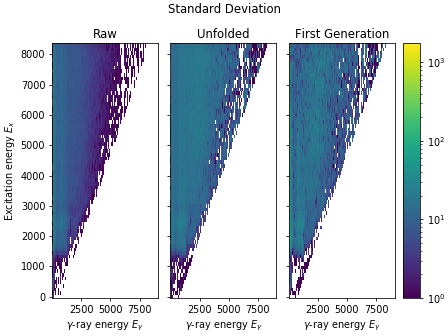

(<Figure size 448x336 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f121b71a978>,
       dtype=object))

In [32]:
ensemble.plot()

## Rebin, normalize fg matrix and export result

In [33]:
fhwm_5000 = R_tab_view.loc[R_tab_view['E'] <= 5000].iloc[-1]["fwhm_abs"]

In [34]:
fhwm_5000 = R_tab_view.loc[R_tab_view['E'] <= 5000].iloc[-1]["fwhm_abs"]
assert fhwm_5000/2 < 150, "If larger, need to decide better between Ex and Eg resolution"
binwidth = ensemble.get_firstgen(0).calibration()["a1x"] # based on Ex resolution; rebinning Eg as rebinning error should be smaller
Egnew = np.arange(ensemble.get_firstgen(0).Ex[0], 
                  ensemble.get_firstgen(0).Eg[-1]+binwidth, binwidth)

fgs = []
for i in range(ensemble.size):
    fg = ensemble.get_firstgen(i).rebin("Eg", mids=Egnew, inplace=False)
    fg.cut("Eg", Eg_min, Eg_max)
    fg.cut("Ex", Ex_min, Ex_max)
    fg.values = om.normalize_rows(fg.values)
    fgs.append(fg)

In [35]:
fg_avg = np.average(np.array([fg.values for fg in fgs]), axis=0)
fg_std = np.std(np.array([fg.values for fg in fgs]), axis=0)

fg_avg = om.Matrix(values=fg_avg, Ex=fg.Ex, Eg=fg.Eg)
fg_std = om.Matrix(values=fg_std, Ex=fg.Ex, Eg=fg.Eg)

<IPython.core.display.Javascript object>


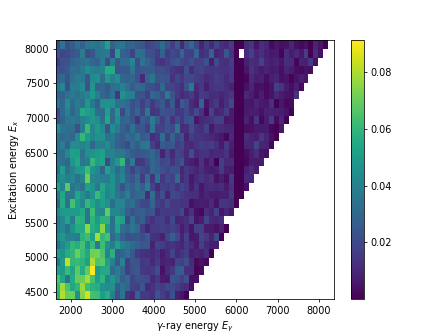

<IPython.core.display.Javascript object>


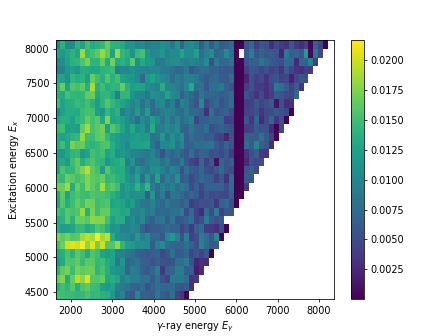

(<matplotlib.collections.QuadMesh at 0x7f121b648c18>,
 <Figure size 448x336 with 2 Axes>)

In [36]:
fg_avg.plot()
fg_std.plot()

In [37]:
iEg = fg_avg.index_Eg(6030)
fg_avg[:, iEg] = np.nan
fg_std[:, iEg] = 0

iEg = fg_avg.index_Eg(6130)
fg_avg[:, iEg] = np.nan
fg_std[:, iEg] = 0

In [38]:
fout = Path("export")
fout.mkdir(exist_ok="True")
fg_avg.save(fout / "1Gen_4He.m")
fg_std.save(fout / "1Gen_4He_std.m")

<IPython.core.display.Javascript object>


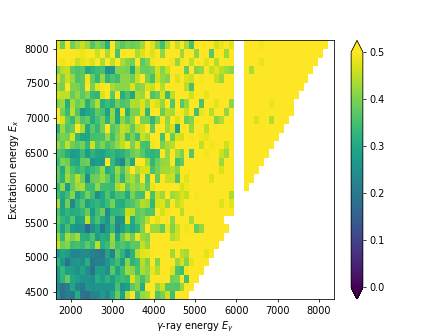

(<matplotlib.collections.QuadMesh at 0x7f1214a60748>,
 <Figure size 448x336 with 2 Axes>)

In [39]:
fg_std_rel = fg_std / fg_avg
fg_std_rel.plot(vmin=0, vmax=0.5)